In [566]:
from s04utils.modules.load import timestamps

from bokeh.plotting import figure, show, output_notebook, curdoc
from matplotlib_inline.backend_inline import set_matplotlib_formats

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


from sfHMM import sfHMM1
from sfHMM.gmm import GMMs

from pybaselines import Baseline

In [567]:
# Set quality for plt plots
set_matplotlib_formats('retina')

# Set output style for bokeh plots
#curdoc().theme = 'dark_minimal'
output_notebook()

Loading BokehJS ...

In [568]:
SOURCE_PATH = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_018.h5'

In [569]:
# Load timestamps from file
ts = timestamps.load_from_path(path=SOURCE_PATH)

In [570]:
# Set bin time in seconds
bin_time = 0.01 # 10ms

# Create binned timetrace
timetrace = ts.get_timetrace_data(bin_width=bin_time)

# Get the binned timetrace data for each individual detector
detector_0 = timetrace['detector0'][0]
detector_1 = timetrace['detector1'][0]

bins0 = timetrace['detector0'][1]
print(bins0)

# Get the binned timetrace data for the sum of both detectors
detector_sum = timetrace['detector0'][0] + timetrace['detector1'][0]

# Create a pandas dataframe
df = pd.DataFrame({'detector0': detector_0, 'detector1': detector_1, 'detector_sum': detector_sum})

[3.78933270e+07 3.98869727e+07 4.18806184e+07 ... 1.17645174e+10
 1.17665111e+10 1.17685047e+10]


58.85249175
11770498350
5885.249175


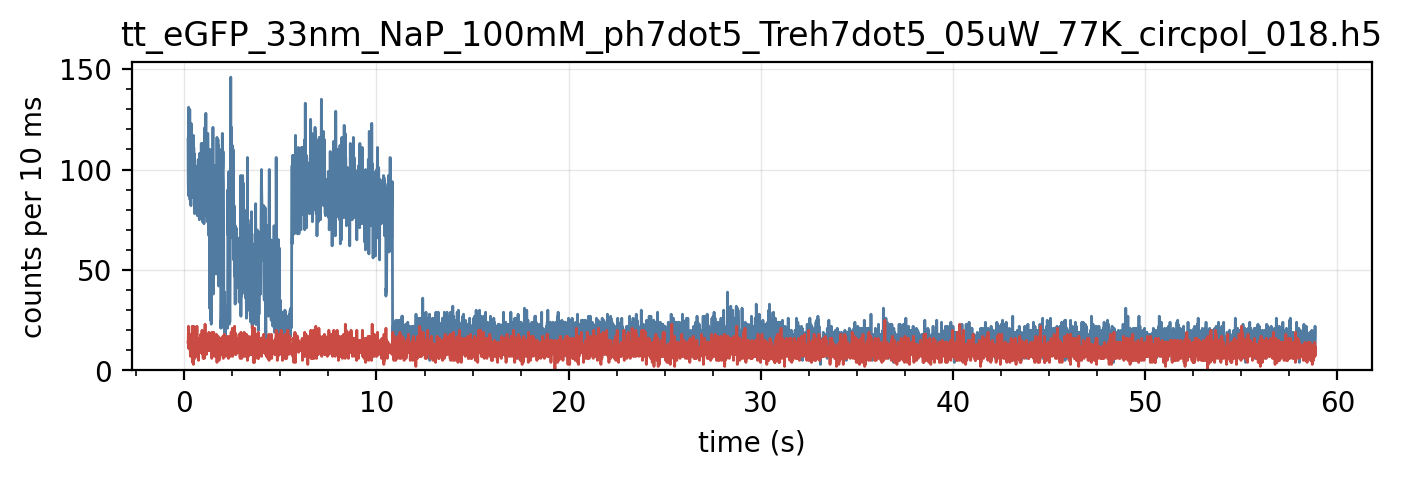

In [571]:
ts.preview()

In [572]:
# compute some values for the plot

timestamps0 = ts.data['detector0'].to_numpy()
timetrace_len = timestamps0[-1]
timetrace_len_in_s = 5e-9 * timetrace_len

# Get digits of bin_time
bin_time_digits = len(str(bin_time).split('.')[1])

# Round timetrace_len_in_s to same number of digits as bin_time
timetrace_len_in_s = round(timetrace_len_in_s, bin_time_digits) - 2*bin_time

x = np.linspace(0, timetrace_len_in_s, len(detector_0))

In [573]:
# create the same plot in bokeh
p = figure(width=800, height=300)
p.line(x=x, y=df['detector_sum'], line_width=1, color='blue', legend_label='detector_sum')
p.line(x=x, y=df['detector0'], line_width=1, color='red', legend_label='detector0')
p.line(x=x, y=df['detector1'], line_width=1, color='green', legend_label='detector1')
p.legend.location = 'top_right'

# Set the axis labels
p.xaxis.axis_label = 'time (s)'
p.yaxis.axis_label = 'counts per ' + str(int(bin_time*1e3)) + ' ms'

show(p)

4


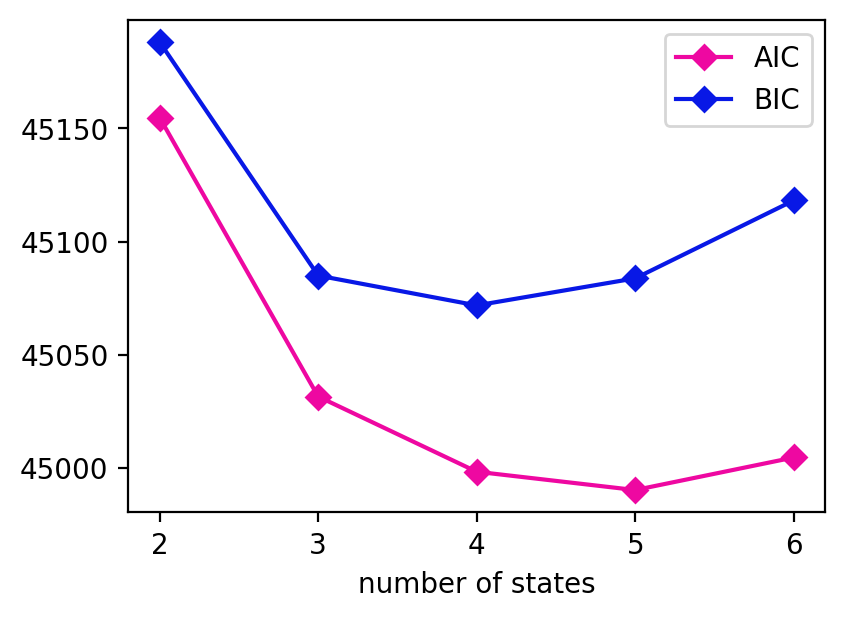

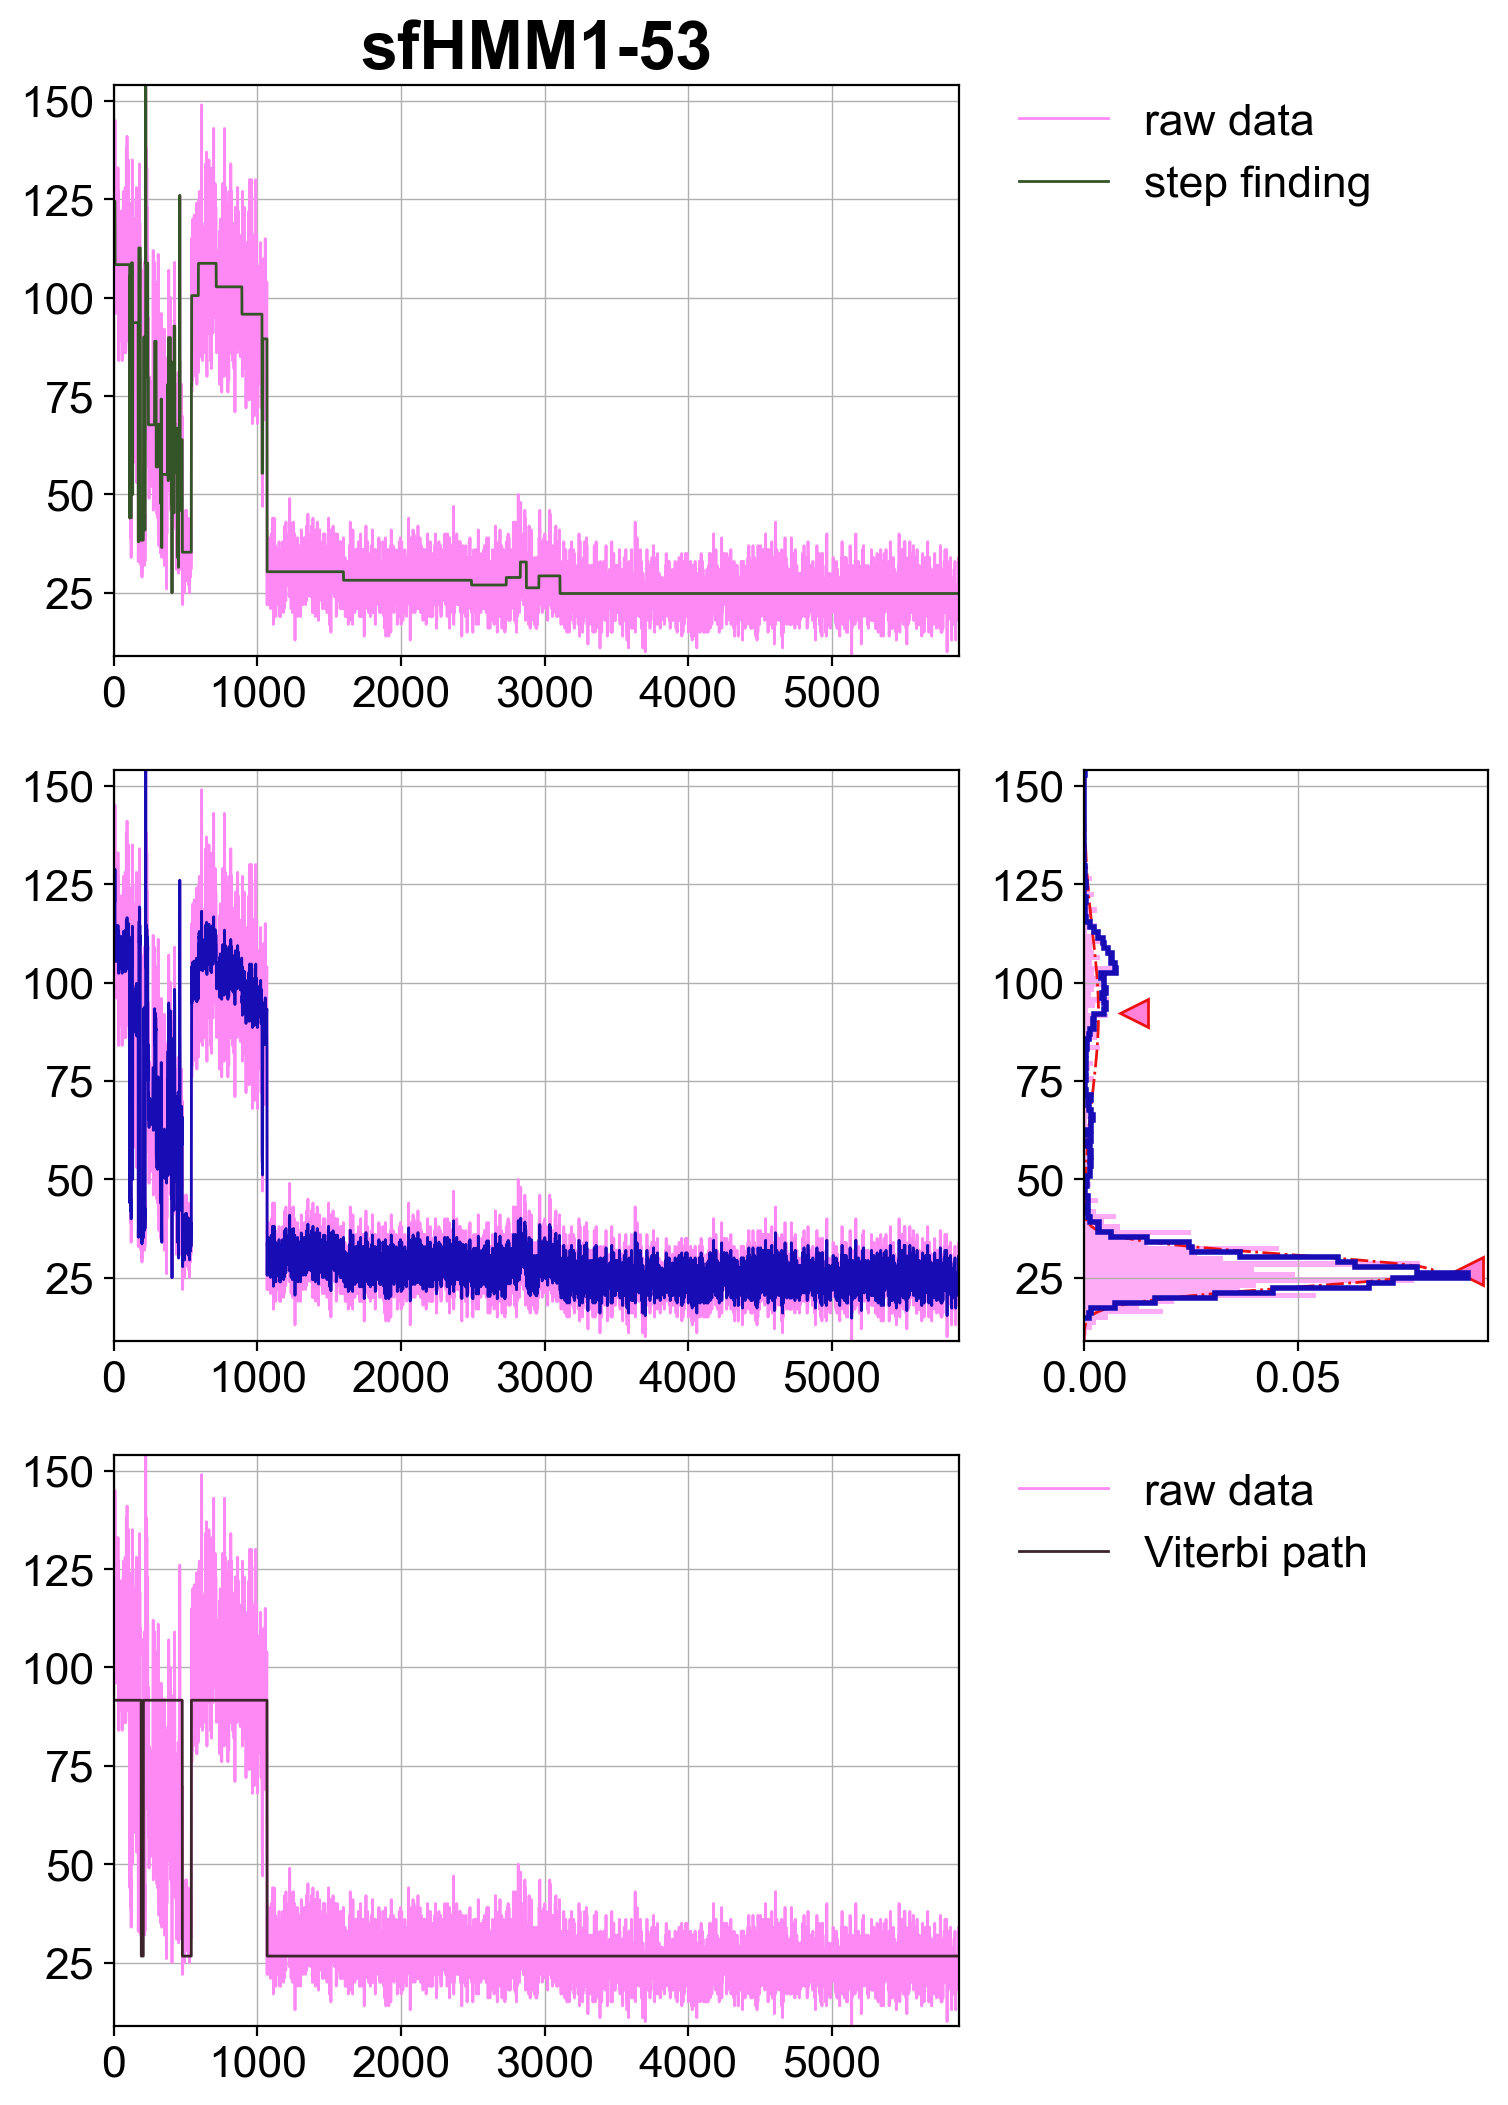

In [574]:
gmms = GMMs(df['detector_sum'], krange=(2, 6))
gmms.fit()
gmms.show_aic_bic()
#gmms.plot_all()


gmms_opt_n = gmms.get_optimal(criterion="bic").n_components

print(gmms_opt_n)

sfp_two_states = sfHMM1(df['detector_sum'], krange=(2, 2), model='p').run_all()

In [575]:
# create the same plot in bokeh
p = figure(width=800, height=300)
#p.line(x=df.index, y=sfp_two_states.data_raw, line_width=1, color='lightgrey', legend_label='detector_sum')
p.line(x=x, y=sfp_two_states.data_fil, line_width=1, color='darkgrey', legend_label='detector0', alpha=0.5)
p.line(x=x, y=sfp_two_states.viterbi, line_width=2, color='red', legend_label='viterbi')
p.legend.location = 'top_right'
p.title.text = f"sfHMM1 with 2 states (forced)"

# Set the axis labels
p.xaxis.axis_label = 'time (s)'
p.yaxis.axis_label = 'counts per ' + str(int(bin_time*1e3)) + ' ms'

show(p)

In [576]:
# create three lists for the three states
state_0 = []
state_1 = []


# initialize variables to keep track of the start and end indices of each interval
start_idx = 0
prev_state = sfp_two_states.states[0]

# iterate over the state values and extract the length of each interval
for i, state in enumerate(sfp_two_states.states):
    if state != prev_state:
        # the state has changed, so we've reached the end of an interval
        end_idx = i - 1
        interval_length = end_idx - start_idx + 1
        if prev_state == 0:
            state_0.append(interval_length)
        elif prev_state == 1:
            state_1.append(interval_length)
        start_idx = i
        prev_state = state

# handle the last interval
end_idx = len(sfp_two_states.states) - 1
interval_length = end_idx - start_idx + 1
if prev_state == 0:
    state_0.append(interval_length)
elif prev_state == 1:
    state_1.append(interval_length)

# print the lengths of the intervals for each state
print("State 0 intervals:", state_0)
print("State 1 intervals:", state_1)

# delete largest interval in state 0
state_0.remove(np.max(state_0))

# convert time intervals to milliseconds ant convert to integer
state_0 = np.array(state_0) * bin_time * 1e3
state_0 = state_0.astype(int)
state_1 = np.array(state_1) * bin_time * 1e3
state_1 = state_1.astype(int)

# get max value from each state
max_state_0 = np.max(state_0)
max_state_1 = np.max(state_1)

# get total max value
max_interval = np.max([max_state_0, max_state_1])

print("State 0 intervals in ms:", state_0)
print("State 1 intervals in ms:", state_1)

State 0 intervals: [15, 63, 4817]
State 1 intervals: [192, 271, 527]
State 0 intervals in ms: [150 630]
State 1 intervals in ms: [1920 2710 5270]


Text(0, 0.5, 'counts')

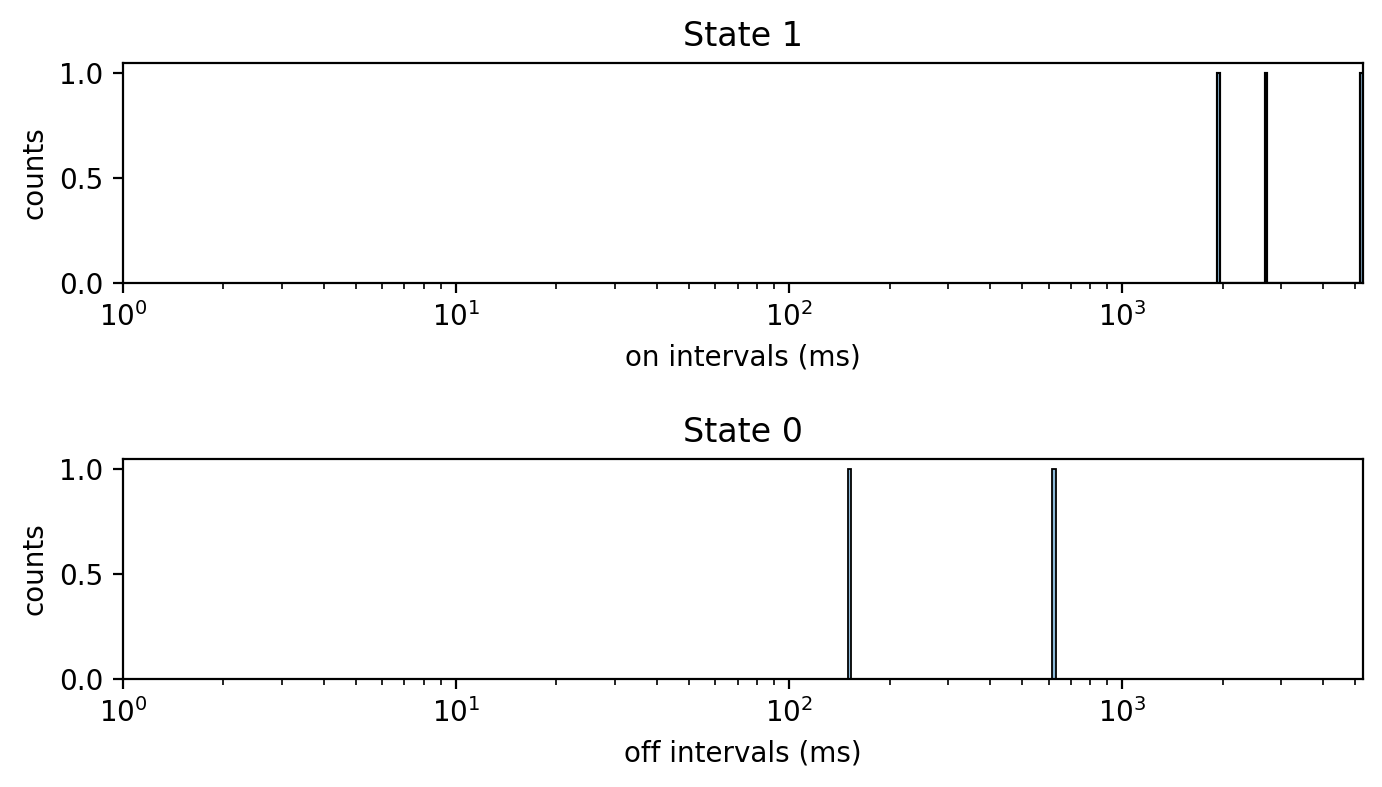

In [577]:
'''# create a figure with three subplots
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# create a histogram for each state
ax0.hist(state_0, bins=range(0, max_interval, 1), color='red')
ax1.hist(state_1, bins=range(0, max_interval, 1), color='green')

# set the title for each subplot
ax0.set_title('State 0')
ax1.set_title('State 1')

# set the x-axis label for the bottom subplot
ax1.set_xlabel('Interval length')

# set the y-axis label for each subplot
ax0.set_ylabel('Count')
ax1.set_ylabel('Count')

plt.show()'''

# Create a figure for two subplots 
fig, ax = plt.subplots(2, 1, figsize=(8,4), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.8)

# seaborn histplot of the on intervals
sns.histplot(state_1, bins=(int(np.max(state_1)/100)), ax=ax[0], alpha=0.5, log_scale=(True, False))
#ax[0].set_yscale('log')

# Set axis labels
ax[0].set_xlabel('on intervals (ms)')
ax[0].set_ylabel('counts')
ax[0].set_xlim(1, np.max(state_1))

ax[0].set_title('State 1')
ax[1].set_title('State 0')


# seaborn histplot of the off intervals
sns.histplot(state_0, bins=(int(np.max(state_0)/10)), ax=ax[1], alpha=0.5, log_scale=(True, False))
#ax[1].set_yscale('log')
#ax[1].set_xscale('log')
ax[1].set_xlim(1, np.max(state_1))

# Set axis labels
ax[1].set_xlabel('off intervals (ms)')
ax[1].set_ylabel('counts')


TypeError: distplot() got an unexpected keyword argument 'y'

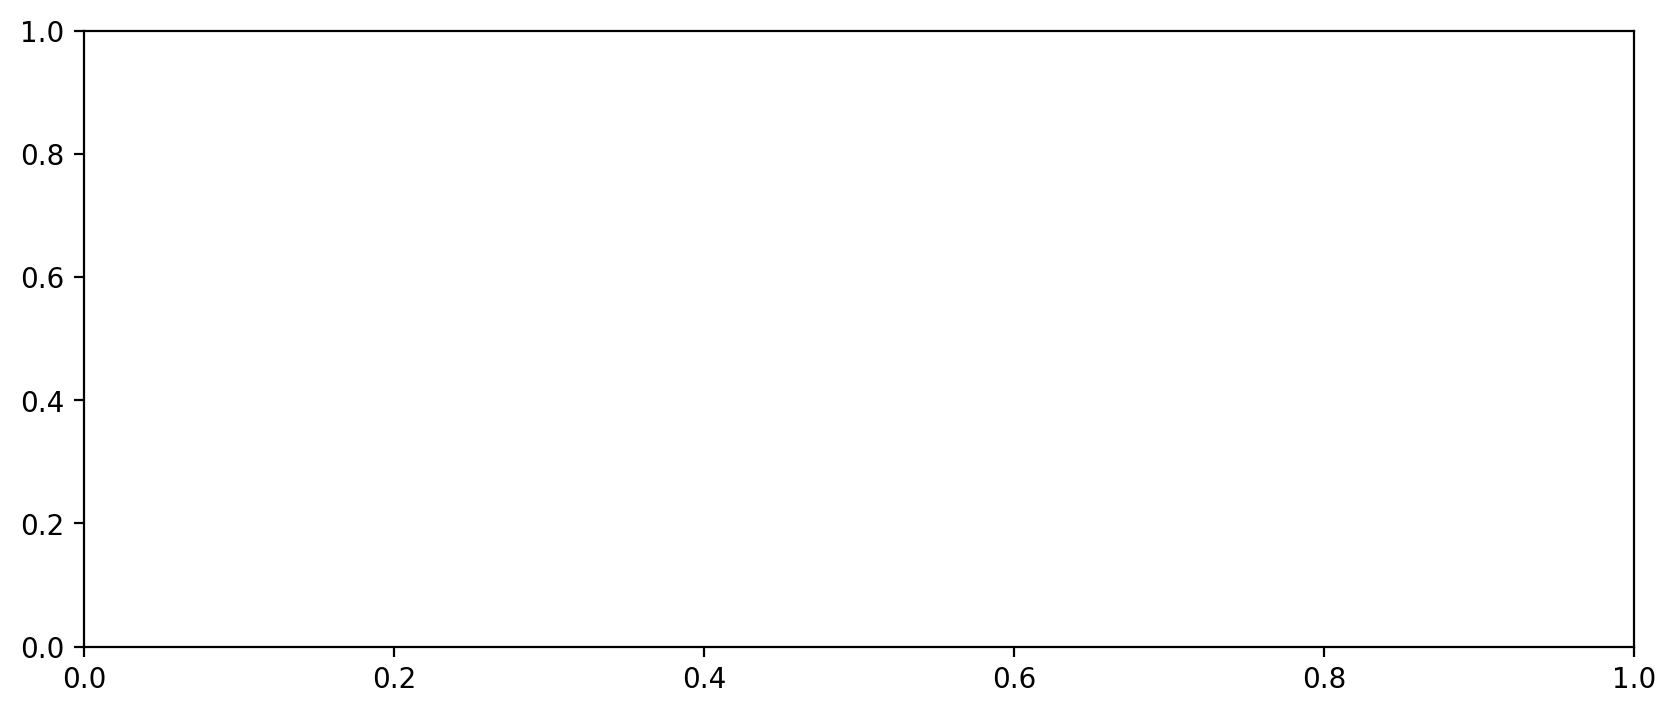

In [578]:
# create the same plot as a seabor barplot
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(x=np.arange(0, np.max(state_1)), y=state_1, ax=ax, color='green', log=True)

{26.6494833722782: 4895, 91.65700036004428: 990}
High state: 91.65700036004428
Low state: 26.6494833722782
Last value change: 1067
Cut offset: 533
5885


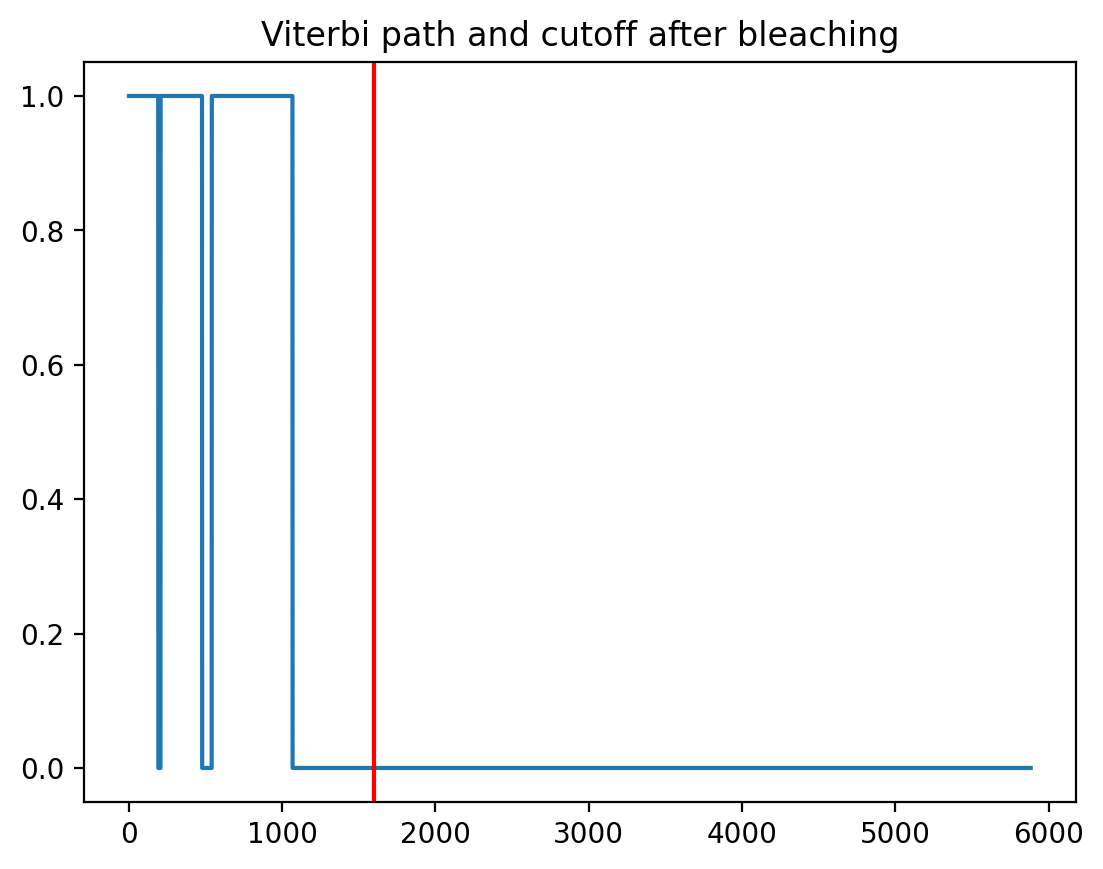

In [579]:
# get the viterbi path
steps_viterbi = sfp_two_states.viterbi

# get unique values
unique, counts = np.unique(steps_viterbi, return_counts=True)
print(dict(zip(unique, counts)))

high_state = unique[1]
low_state = unique[0]

print('High state: ' + str(high_state))
print('Low state: '+ str(low_state))

steps = steps_viterbi.copy()

# assign 0 and 1 to the states in viterbi path
steps[steps_viterbi == high_state] = 1
steps[steps_viterbi == low_state] = 0

# find indices where the state changes
value_change = np.where(np.diff(steps))[0]

last_value_change = value_change[-1]

# set cutoff value
CUT_OFFSET = int(last_value_change / 2)
print('Last value change: ' + str(last_value_change))
print('Cut offset: ' + str(CUT_OFFSET))
print(len(steps))

# correct CUT_OFFSET if it is too large
if (last_value_change + CUT_OFFSET) > len(steps):
    print('Offset out of bounds, correcting offset')
    CUT_OFFSET = steps[-1] + 1

# plot the last value chnage as a vertical line
plt.plot(steps)
plt.axvline(last_value_change+CUT_OFFSET, color='red')
plt.title('Viterbi path and cutoff after bleaching')
plt.show()

In [580]:
cutoff_index = int(value_change[-1]+CUT_OFFSET)
print(cutoff_index)

1600


3


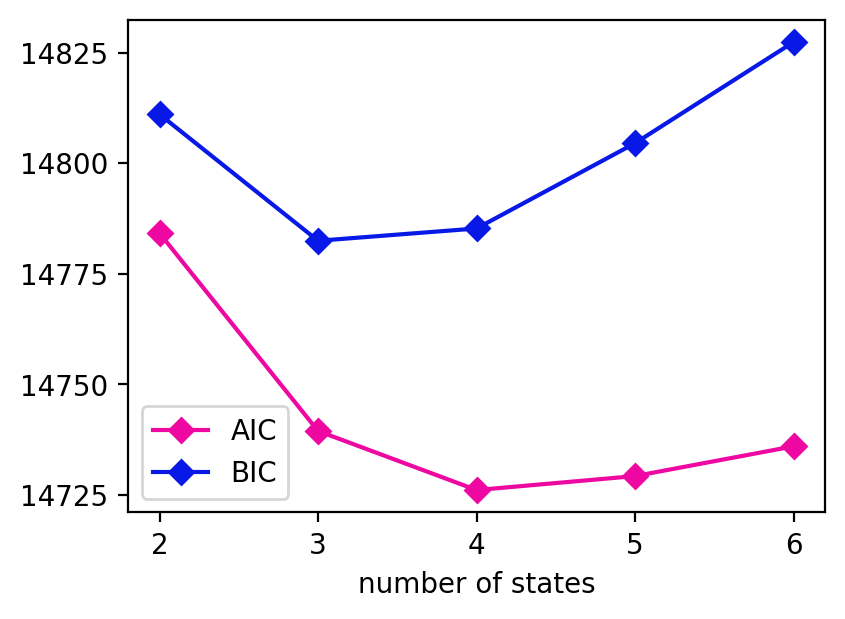

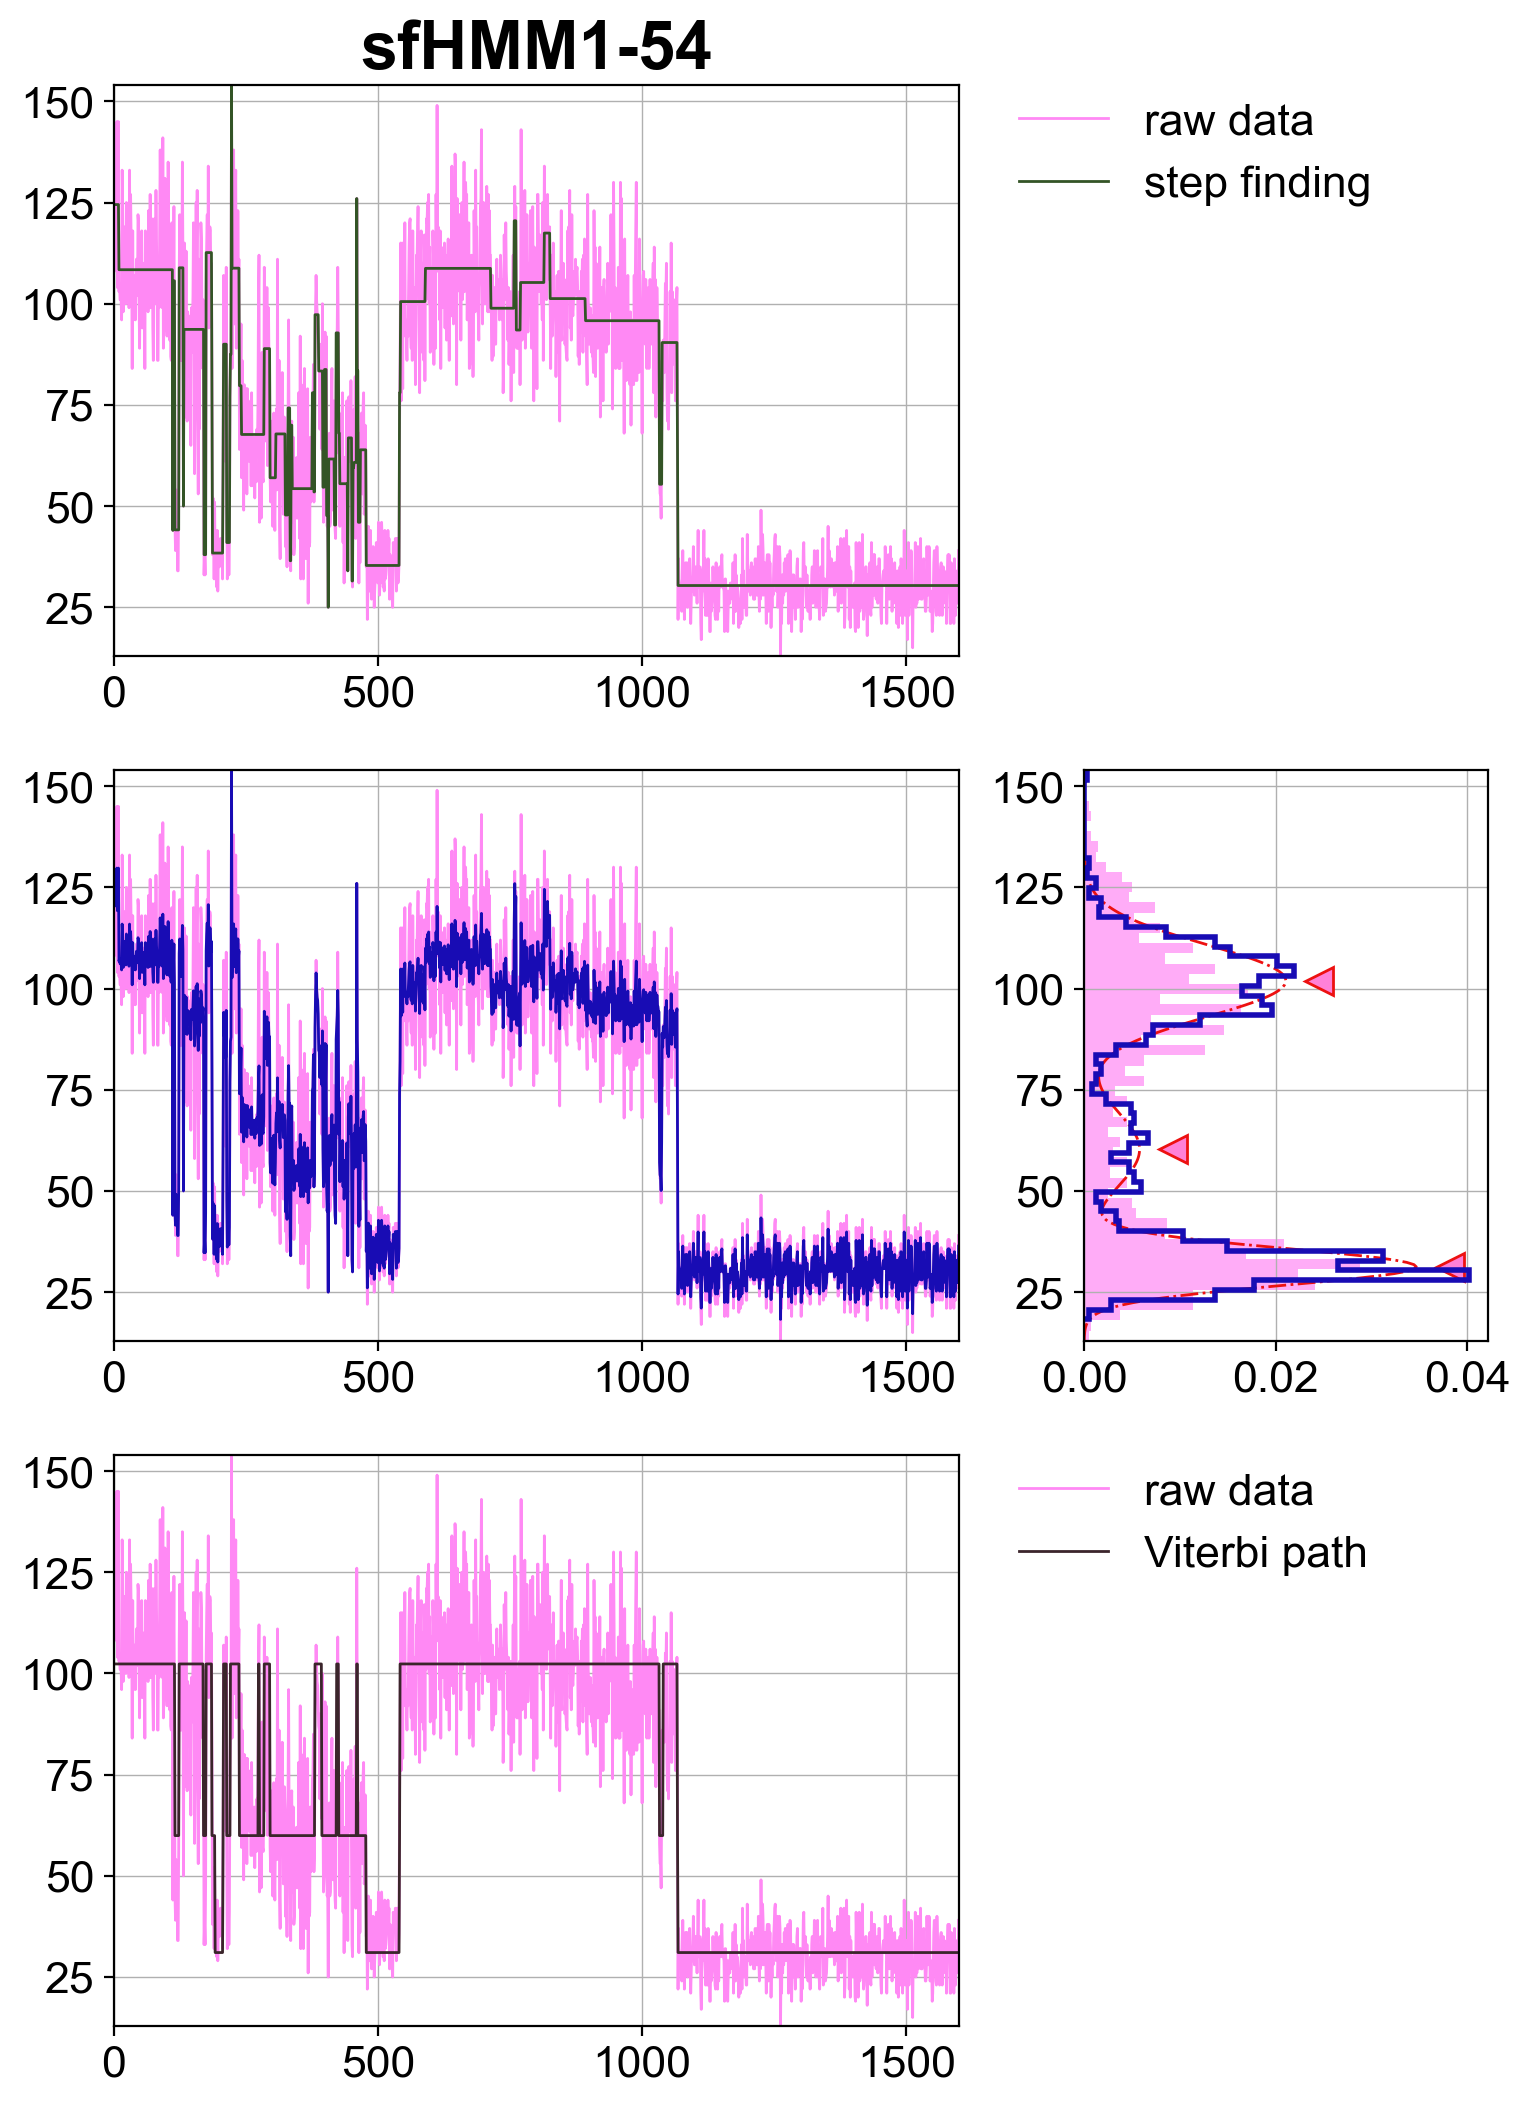

In [581]:
# cut the data at the last value change
df_cut = df.iloc[:cutoff_index]

gmms = GMMs(df_cut['detector_sum'], krange=(2, 6))
gmms.fit()
gmms.show_aic_bic()
#gmms.plot_all()


gmms_opt_n = gmms.get_optimal(criterion="bic").n_components

print(gmms_opt_n)

sfp = sfHMM1(df_cut['detector_sum'], krange=(2, gmms_opt_n), model='p').run_all()

sf.sg0 =
 4.006666666666667
sfp.n_components =
 3
sfp.means_ =
 [[ 31.03682571]
 [ 59.93249902]
 [102.33905962]]
sfp.states =
 [2 2 2 ... 0 0 0]


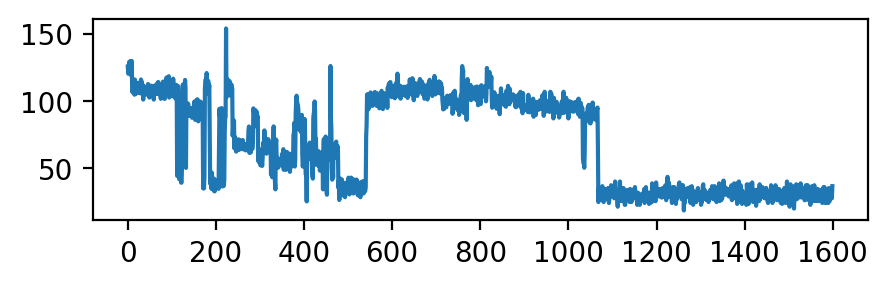

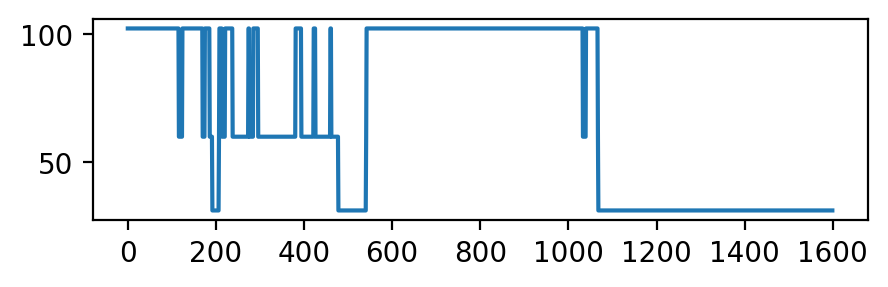

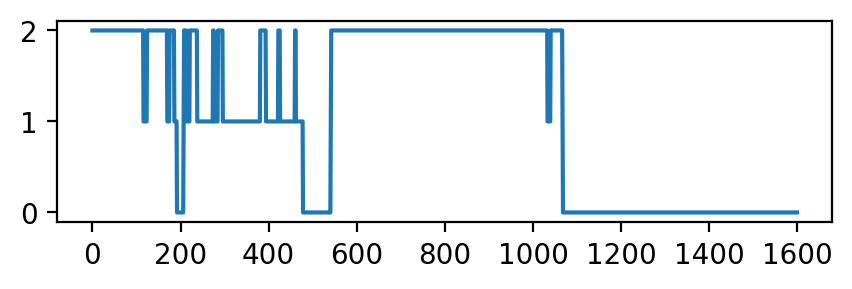

In [582]:
print("sf.sg0 =\n", sfp.sg0)
print("sfp.n_components =\n", sfp.n_components)
print("sfp.means_ =\n", sfp.means_)
print("sfp.states =\n", sfp.states)
plt.figure(figsize=(5, 1.3))
plt.plot(sfp.data_fil)
plt.show()
plt.figure(figsize=(5, 1.3))
plt.plot(sfp.viterbi)
plt.show()
plt.figure(figsize=(5, 1.3))
plt.plot(sfp.states)
plt.show()

In [583]:
# create the same plot in bokeh
p = figure(width=800, height=300)
#p.line(x=df_cut.index, y=sfp.data_raw, line_width=1, color='lightgrey', legend_label='data_raw')
p.line(x=x, y=sfp.data_fil, line_width=1, color='darkgrey', legend_label='detector0', alpha=0.5)
p.line(x=x, y=sfp.viterbi, line_width=2, color='red', legend_label='viterbi')
p.legend.location = 'top_right'
p.title.text = f"sfHMM1 with {gmms_opt_n} states (calculated optimum)"

# Set the axis labels
p.xaxis.axis_label = 'time (s)'
p.yaxis.axis_label = 'counts per ' + str(int(bin_time*1e3)) + ' ms'

show(p)

In [584]:
# create three lists for the three states
state_0 = []
state_1 = []
state_2 = []

# initialize variables to keep track of the start and end indices of each interval
start_idx = 0
prev_state = sfp.states[0]

# iterate over the state values and extract the length of each interval
for i, state in enumerate(sfp.states):
    if state != prev_state:
        # the state has changed, so we've reached the end of an interval
        end_idx = i - 1
        interval_length = end_idx - start_idx + 1
        if prev_state == 0:
            state_0.append(interval_length)
        elif prev_state == 1:
            state_1.append(interval_length)
        elif prev_state == 2:
            state_2.append(interval_length)
        start_idx = i
        prev_state = state

# handle the last interval
end_idx = len(sfp.states) - 1
interval_length = end_idx - start_idx + 1
if prev_state == 0:
    state_0.append(interval_length)
elif prev_state == 1:
    state_1.append(interval_length)
elif prev_state == 2:
    state_2.append(interval_length)

# print the lengths of the intervals for each state
print("State 0 intervals:", state_0)
print("State 1 intervals:", state_1)
print("State 2 intervals:", state_2)

# get max value from each state
max_state_0 = np.max(state_0)
max_state_1 = np.max(state_1)
max_state_2 = np.max(state_2)

# get total max value
max_interval = np.max([max_state_0, max_state_1, max_state_2])

# multiply each time interval by the bin time to get the time in seconds

State 0 intervals: [15, 63, 532]
State 1 intervals: [8, 5, 6, 1, 7, 36, 9, 85, 28, 34, 16, 1, 7, 1]
State 2 intervals: [116, 46, 11, 6, 17, 2, 11, 13, 4, 2, 491, 27]


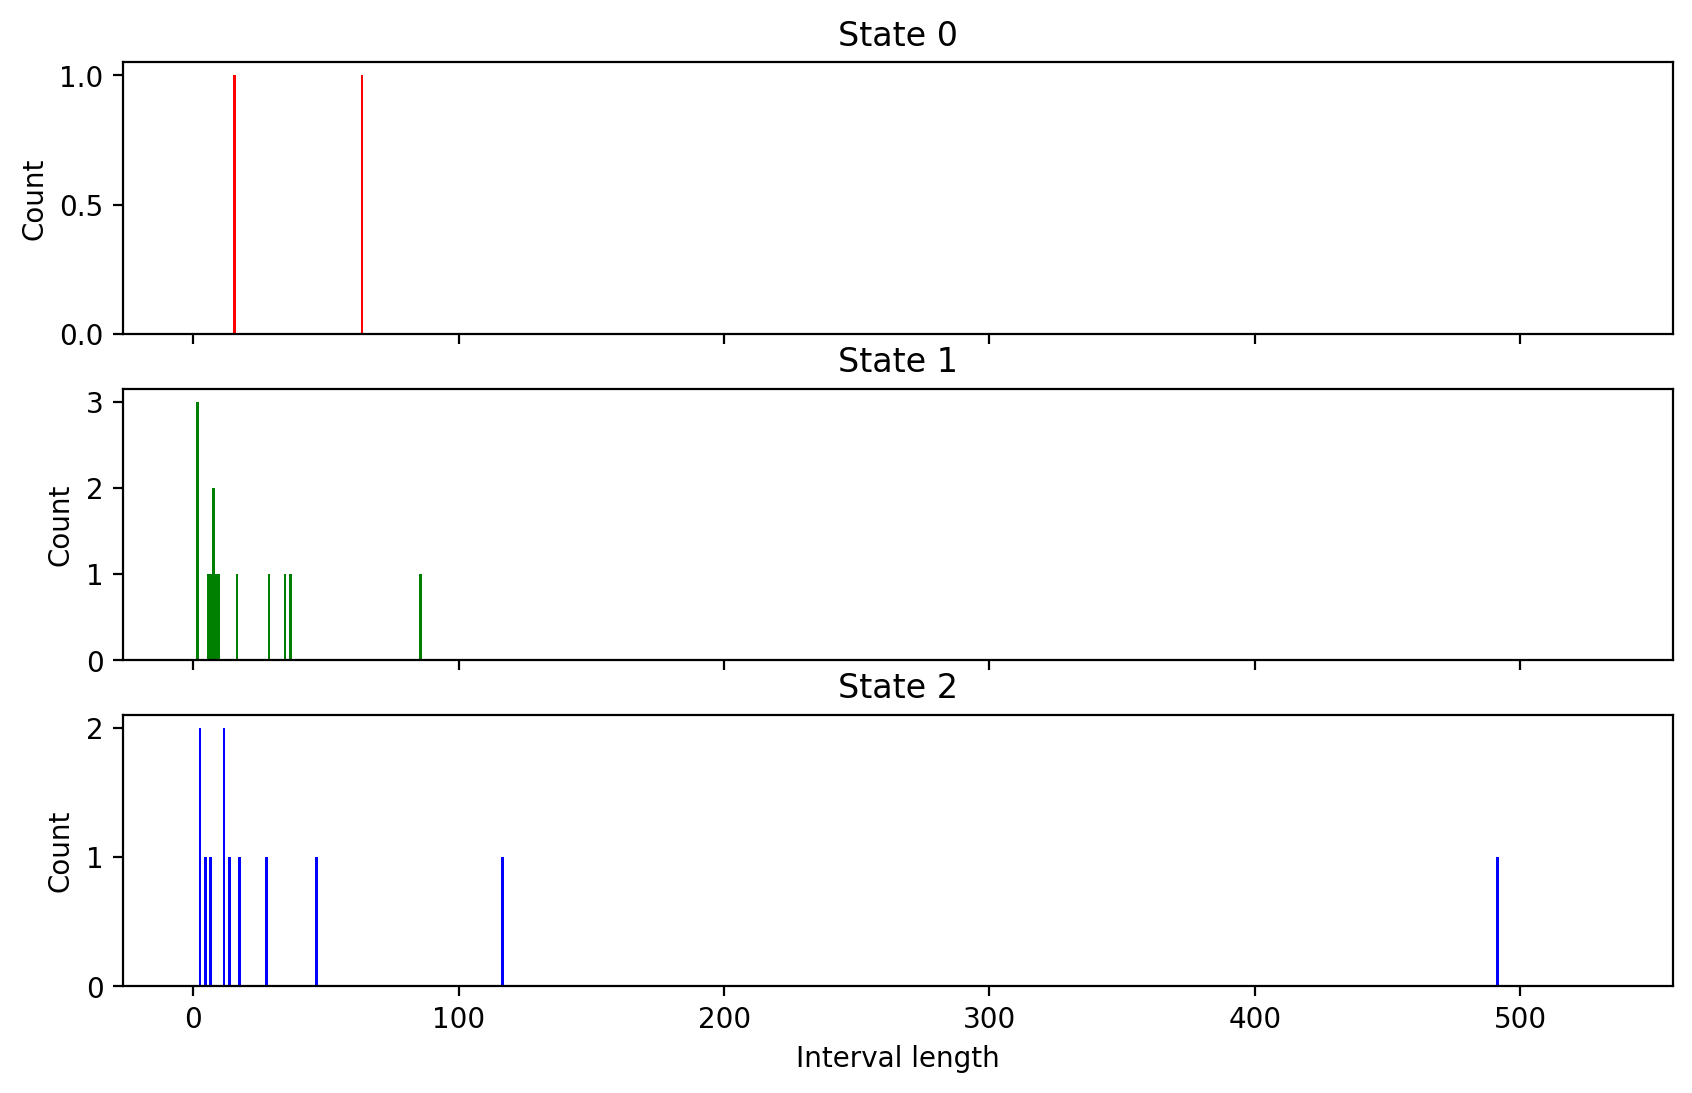

In [585]:
# create a figure with three subplots
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# create a histogram for each state
ax0.hist(state_0, bins=range(0, max_interval, 1), color='red')
ax1.hist(state_1, bins=range(0, max_interval, 1), color='green')
ax2.hist(state_2, bins=range(0, max_interval, 1), color='blue')

# set the title for each subplot
ax0.set_title('State 0')
ax1.set_title('State 1')
ax2.set_title('State 2')

# set the x-axis label for the bottom subplot
ax2.set_xlabel('Interval length')

# set the y-axis label for each subplot
ax0.set_ylabel('Count')
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')

plt.show()


Text(0.5, 1.0, 'State 2')

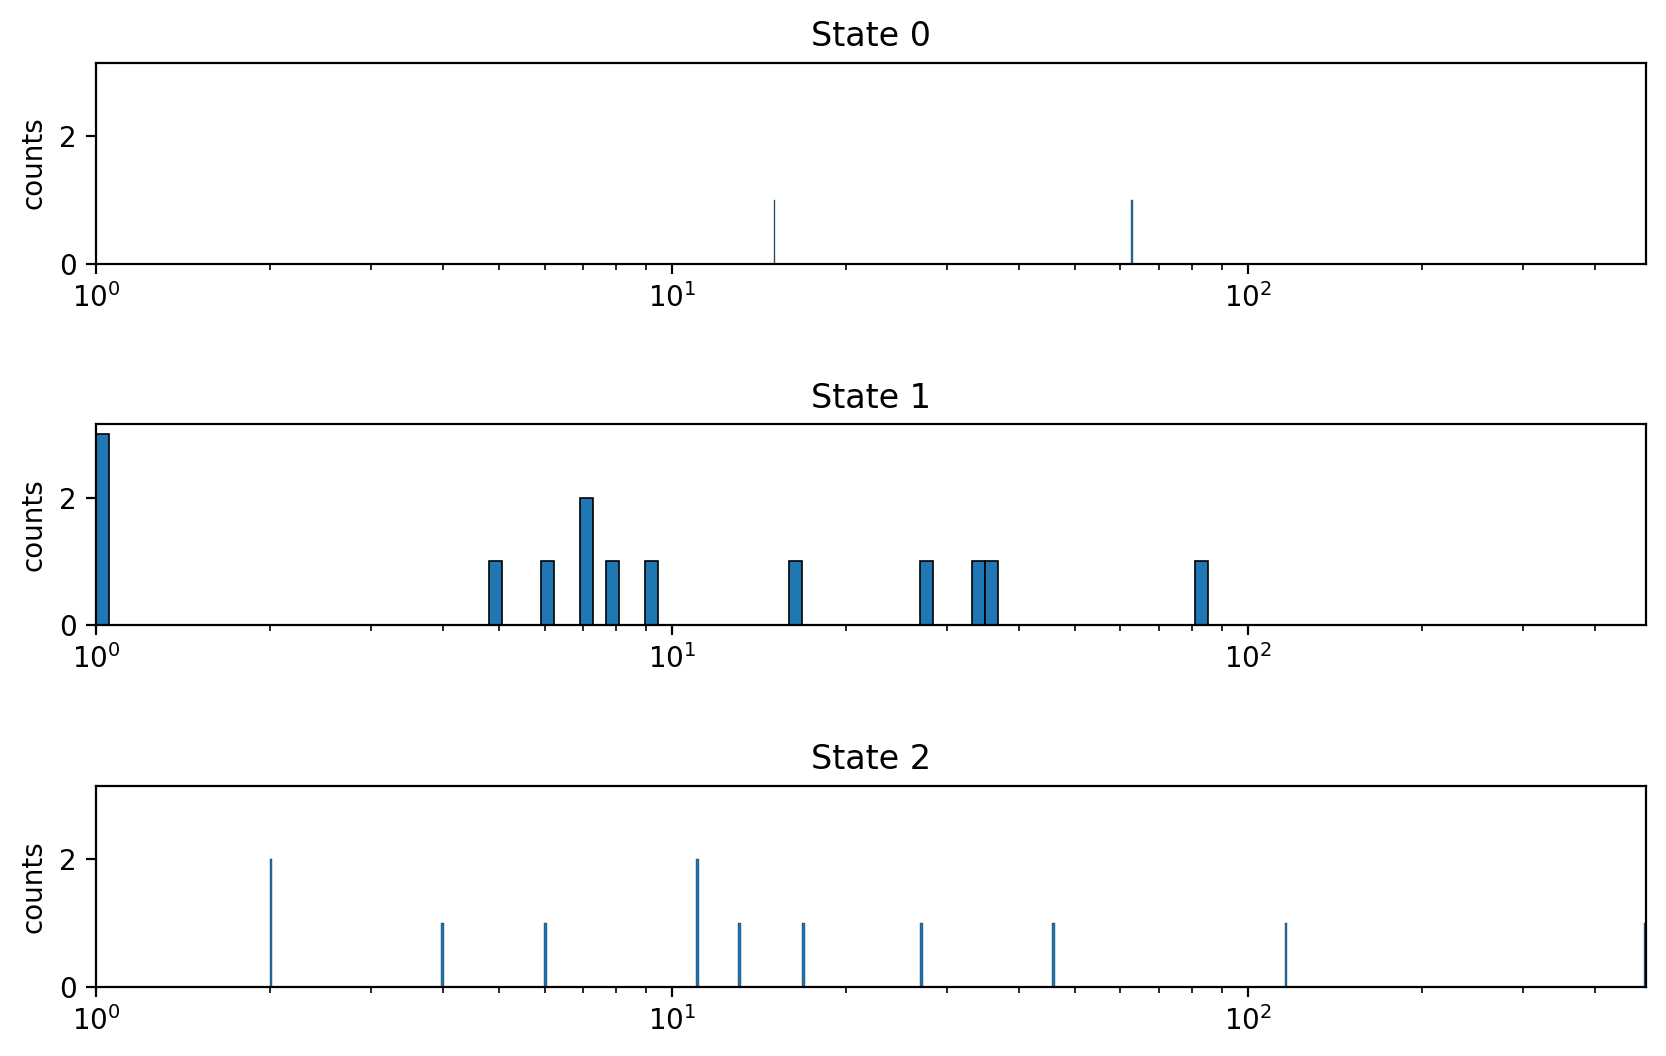

In [591]:
# Create a figure for two subplots 
fig, ax = plt.subplots(3, 1, figsize=(10,6), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.8)

# seaborn histplot of the on intervals
sns.histplot(state_0, bins=(int(np.max(state_0))), ax=ax[0], alpha=1, log_scale=(True, False))
ax[0].set_xlim(1, np.max(state_2))

# Set axis labels
#ax[0].set_xlabel('on intervals (ms)')
ax[0].set_ylabel('counts')
ax[0].set_title('State 0')

# seaborn histplot of the off intervals
sns.histplot(state_1, bins=(int(np.max(state_1))), ax=ax[1], alpha=1, log_scale=(True, False))
ax[1].set_xlim(1, np.max(state_2))

# Set axis labels
#ax[1].set_xlabel('off intervals (ms)')
ax[1].set_ylabel('counts')
ax[1].set_title('State 1')

# seaborn histplot of the off intervals
sns.histplot(state_2, bins=(int(np.max(state_2))), ax=ax[2], alpha=1, log_scale=(True, False))
ax[2].set_xlim(1, np.max(state_2))

# Set axis labels
#ax[2].set_xlabel('off intervals (ms)')
ax[2].set_ylabel('counts')
ax[2].set_title('State 2')